## Reinforcement learning - TME 4 - DQN

L'objectif du TME est d'implémenter les algorithmes de renforcement value-based étudiés en cours (Q-learning et ses variantes) et de les tester dans un framework classique (gym de open-ai, MDP GridWorld).

In [1]:
from matplotlib import pyplot as plt

import gym
import gridworld
from gym import wrappers, logger
import numpy as np
import copy
import torch
from torch import nn

### Implémentation des algorithmes 

In [2]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return np.random.choice([0, 1])
    
    def learn(self, observation, reward, done):
        return

In [3]:
class NN(nn.Module):
    def __init__(self, inSize, outSize, layers=[]):
        super(NN, self).__init__()
        self.layers = nn.ModuleList([])
        for x in layers:
            self.layers.append(nn.Linear(inSize, x))
            inSize = x
        self.layers.append(nn.Linear(inSize, outSize))
        
    def forward(self, x):
        x = self.layers[0](x)
        for i in range(1, len(self.layers)):
            x = torch.nn.functional.leaky_relu(x)
            x = self.layers[i](x)
        return x

Paramètres CartPole

epsilon=0.01, epsilonDecay=0.99999
gamma=0.999
btachSize=100, capacity=100000
ctarget=100
layers=[200]
lr=0.001

LunarLander (convergence après environ 10000 episodes):
epsilon=0.1, epsilonDecay=0.99999
gamma=0.99
btachSize=1, capacity=1
ctarget=1000
layers=[200]
lr=0.0001

  Pour Gridworld  (convergence après environ 2000 episodes sur plan0 avec rewards={0:-0.001,3:1,4:1,5:-1,6:-1}):
epsilon=0.1, epsilonDecay=0.9999 (epsilon multiplié par epsilonDecay à chaque passage dans act)
gamma=0.99
batchSize=10, capacity=1000000
ctarget=1000 (fréquence de mise à jour du réseau cible)
layers=[30,30]
lr=0.0001 (learning rate)

In [4]:
class DQN(object):
    """Implementing a DQN learning agent"""

    def __init__(self, env, params):
        self.env = env
        self.N = params['N']
        self.D = torch.zeros((self.N, 4 + 1 + 1 + 4 + 1))
        self.C = params['C']
        self.batch = params['batch']
        self.Q = NN(5, 1, params['layers'])
        self.Qhat = NN(5, 1, params['layers'])
        self.eps = params['eps']
        self.epsDecay = params['epsDecay']
        self.state = None
        self.step = -1
        self.gamma = params['gamma']
        self.loss = torch.nn.SmoothL1Loss()
        self.optim = torch.optim.Adam(params=self.Q.parameters(), lr=params['lr'])
        
    def act(self, observation, reward, done):
        self.state = torch.from_numpy(observation).float()
        if np.random.rand() < self.eps:
            self.action = np.random.choice([0, 1])
        else:
            input0 = torch.cat((self.state, torch.tensor([0.])))
            input1 = torch.cat((self.state, torch.tensor([1.])))
            self.action = 0 if self.Q(input0) > self.Q(input1) else 1
            
        self.eps *= self.epsDecay
        return self.action
    
    def learn(self, observation, reward, done):
        self.step += 1
        self.D[self.step % self.N] = torch.tensor(list(self.state) + [self.action, reward] + list(observation) + [int(done)])
              
        inputs = self.D[np.random.randint(0, min(self.N, self.step+1), self.batch)]
        x = inputs[:, 0:5]
        rewards = inputs[:, 5]
        
        input0 = torch.cat((inputs[:, 6:10], torch.zeros((self.batch, 1))), dim=1)
        input1 = torch.cat((inputs[:, 6:10], torch.ones((self.batch, 1))), dim=1)
        y = rewards + self.gamma * (1-inputs[:, -1]) * torch.max(torch.cat([self.Qhat(input0), self.Qhat(input1)], dim=1), dim=1)[0]
        
        self.optim.zero_grad()
        l = self.loss(y, self.Q(x).flatten())
        l.backward()
        self.optim.step()
        
        if (self.step % self.C) == 0:
            self.Qhat = copy.deepcopy(self.Q)
        

In [5]:
env = gym.make('CartPole-v1')
#env.seed(0)  # Initialise le seed du pseudo-random
#np.random.seed(5)
params1 = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':100, 'lr':0.005, 'layers':[200], 'gamma':0.999, 'N':100000}
params2 = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':1, 'lr':0.005, 'layers':[200], 'gamma':0.999, 'N':1}
params2bis = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':100, 'lr':0.005, 'layers':[200], 'gamma':0.999, 'N':1}
params2ter = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':1, 'lr':0.005, 'layers':[200], 'gamma':0.999, 'N':100000}
params3 = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':100, 'lr':0.005, 'layers':[50], 'gamma':0.999, 'N':100000}
params4 = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':100, 'lr':0.005, 'layers':[20], 'gamma':0.999, 'N':100000}
params5 = {'eps':0.01, 'epsDecay':0.99999, 'batch':100, 'C':100, 'lr':0.005, 'layers':[5], 'gamma':0.999, 'N':100000}

n_params = 7
n_repeats = 10
n_iterations = 1000
list_rsum = np.zeros((n_params, n_repeats, n_iterations))

n_p = 0
for p in [params1, params2, params2bis, params2ter, params3, params4, params5]:
    print('Beginning parameters ' + str(p))
    agent = DQN(env, p)

    outdir = outdir = 'cartpole-v0/random-agent-results'
    envm = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
    
    for i in range(n_repeats):
        print('Beginning repeat %d' % (i))
        for j in range(n_iterations):
            rsum = 0
            obs = envm.reset()
            reward = 0 
            done = False 

            while True:
                action = agent.act(obs, reward, done)
                obs, reward, done, _ = envm.step(action)
                agent.learn(obs, reward, done)
                rsum += reward
                if done:
                    break
            list_rsum[n_p, i, j]=rsum
    env.close()
    
    n_p += 1
    
np.save("results_cartpole", list_rsum)

Beginning parameters {'eps': 0.01, 'epsDecay': 0.99999, 'batch': 100, 'C': 100, 'lr': 0.005, 'layers': [200], 'gamma': 0.999, 'N': 100000}
Beginning repeat 0
Beginning repeat 1
Beginning repeat 2
Beginning repeat 3
Beginning repeat 4
Beginning repeat 5
Beginning repeat 6
Beginning repeat 7
Beginning repeat 8
Beginning repeat 9
Beginning parameters {'eps': 0.01, 'epsDecay': 0.99999, 'batch': 100, 'C': 1, 'lr': 0.005, 'layers': [200], 'gamma': 0.999, 'N': 1}
Beginning repeat 0
Beginning repeat 1
Beginning repeat 2
Beginning repeat 3
Beginning repeat 4
Beginning repeat 5
Beginning repeat 6
Beginning repeat 7
Beginning repeat 8
Beginning repeat 9
Beginning parameters {'eps': 0.01, 'epsDecay': 0.99999, 'batch': 100, 'C': 100, 'lr': 0.005, 'layers': [200], 'gamma': 0.999, 'N': 1}
Beginning repeat 0
Beginning repeat 1
Beginning repeat 2
Beginning repeat 3
Beginning repeat 4
Beginning repeat 5
Beginning repeat 6
Beginning repeat 7
Beginning repeat 8
Beginning repeat 9
Beginning parameters {'ep

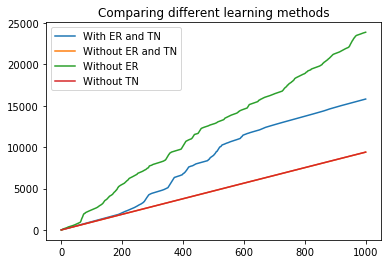

In [4]:
list_rsum = np.load("results_cartpole.npy")
plt.plot(np.cumsum(np.mean(list_rsum[0], axis=0)), label='With ER and TN')
plt.plot(np.cumsum(np.mean(list_rsum[1], axis=0)), label='Without ER and TN')
plt.plot(np.cumsum(np.mean(list_rsum[2], axis=0)), label='Without ER')
plt.plot(np.cumsum(np.mean(list_rsum[3], axis=0)), label='Without TN')
plt.legend()
plt.title('Comparing different learning methods')
plt.show()

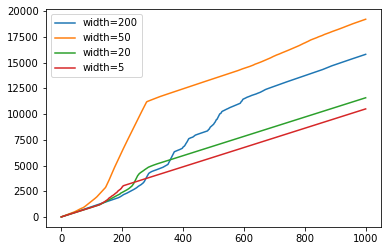

In [5]:
plt.plot(np.cumsum(np.mean(list_rsum[0], axis=0)), label='width=200')
plt.plot(np.cumsum(np.mean(list_rsum[4], axis=0)), label='width=50')
plt.plot(np.cumsum(np.mean(list_rsum[5], axis=0)), label='width=20')
plt.plot(np.cumsum(np.mean(list_rsum[6], axis=0)), label='width=5')
plt.legend()
plt.show()

In [10]:
np.cumsum(list_rsum[0], axis=1).shape

(10, 1000)

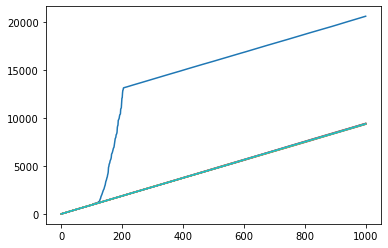

In [19]:
plt.plot(np.cumsum(list_rsum[6], axis=1).T)
plt.show()

In [7]:
500*1000

500000